In [1]:
import random
import numpy as np
import math
import mesa
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from mesa import Agent, Model
from mesa.time import BaseScheduler
from collections import deque
import pandas as pd
from SCN.agent import Order, Customer, Manufacturer, Supplier
from SCN.model import update_transport_cost_for_order, SupplyChainGridModel, calculate_unit_cost_window, calculate_ratio_window, haversine_km

D:\python\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv("SCN/supply_chain_data.csv")
df.rename(columns={"Stock levels": "inventory"}, inplace=True)
df["inventory"] = df["inventory"].apply(lambda x: math.ceil(x) if pd.notnull(x) else x)
df["Order quantities"] = df["Order quantities"].apply(lambda x: math.ceil(x) if pd.notnull(x) else x)
df = df[["inventory", "Order quantities"]]
inventory_count = df["inventory"].count()
order_qty_count = df["Order quantities"].count()
print("inventory 列数据个数（非空）:", inventory_count)
print("Order quantities 列数据个数（非空）:", order_qty_count)
print(df.head())
demands_list = df["Order quantities"].dropna().tolist()
inventory_list = df["inventory"].dropna().astype(int).tolist()
inventory_mean = df["inventory"].mean()
order_qty_mean = df["Order quantities"].mean()

print(f"Inventory 列的均值: {inventory_mean}")
print(f"Order quantities 列的均值: {order_qty_mean}")

inventory 列数据个数（非空）: 100
Order quantities 列数据个数（非空）: 100
   inventory  Order quantities
0         58                96
1         53                37
2          1                88
3         23                59
4          5                56
Inventory 列的均值: 47.77
Order quantities 列的均值: 49.22


In [3]:
import networkx as nx

def get_weighted_edge_count(model, win=50):
    """
    统计最近 win 步窗口内（含当前步）完成的产品订单，
    以订单数量为权重汇总边数。
    """
    window_begin = model.schedule.steps - win
    G = nx.MultiGraph()

    # 把所有代理作为节点加入
    for agent in model.schedule.agents:
        G.add_node(agent.unique_id)

    # 只考虑窗口内完成、已发货、且类型为 product 的订单
    for order in model.delivered_orders:
        if (order.order_type == "product"
            and order.completed
            and order.shipped
            and order.completed_step > window_begin):          # 直接用 completed_step
            G.add_edge(order.sender_id,
                       order.receiver_id,
                       weight=order.quantity)

    # 汇总权重
    total_weight = sum(data["weight"] for _, _, data in G.edges(data=True))
    return total_weight

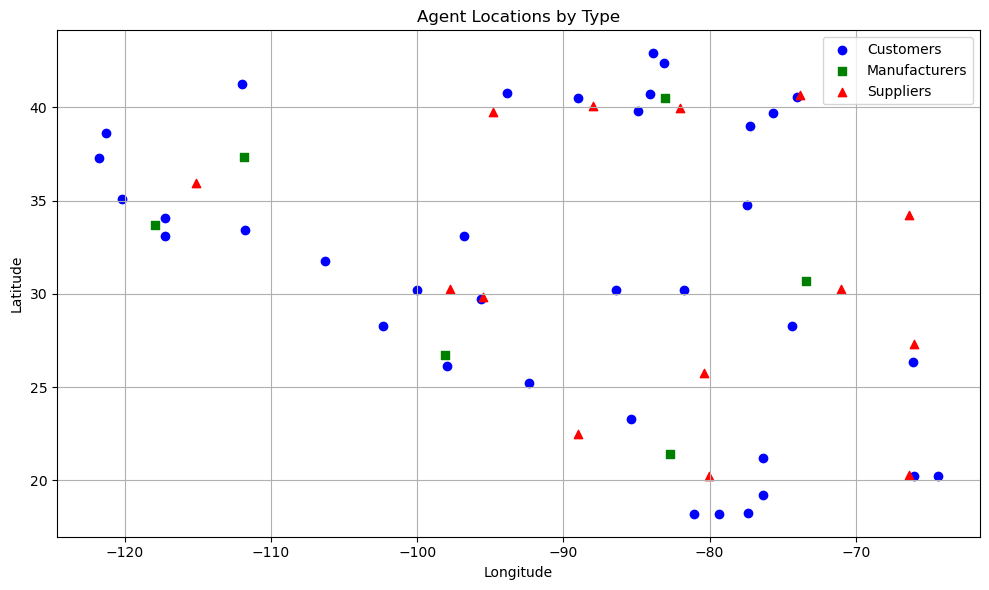

In [4]:
cust_pos = [
    (34.077606, -117.240181), (20.210739, -64.370605),  (38.611774, -121.282867),
    (26.145800, -97.958252),  (34.748348, -77.428482),  (40.763580, -93.830040),
    (23.285648, -85.370613),  (40.508579, -88.982643),  (40.575642, -73.995209),
    (33.089520, -117.255203), (19.228659, -76.370560),  (18.212404, -81.037056),
    (29.696537, -95.645920),  (39.000355, -77.227814),  (41.274368, -111.962868),
    (30.216906, -86.370514),  (30.223112, -100.037056),  (28.261724, -102.370583),
    (21.203922, -76.370613),  (20.253136, -66.037064),  (30.181829, -81.741158),
    (18.260290, -77.370575),  (39.827408, -84.890228),  (35.078728, -120.203323),
    (31.743509, -106.304138), (40.706020, -84.086853),  (25.223833, -92.370514),
    (37.287724, -121.764404), (18.223146, -79.370567),  (42.892185, -83.862381),
    (39.681881, -75.644211),  (42.391102, -83.131218),  (26.359011, -66.078171),
    (33.087120, -96.823570),  (33.410011, -111.771797), (28.268904, -74.370522)
]

man_pos = [
    (33.676708, -117.921905), (21.412319, -82.692352),
    (30.686657, -73.375534),  (40.513103, -83.021828),
    (26.697084, -98.124062),  (37.312534, -111.870071)
]

sup_pos = [
    (22.496193, -88.990883),  (30.258694, -97.766251),
    (40.675449, -73.811142),  (20.280403, -66.370575),
    (39.746620, -94.816437), (25.740225, -80.361694),
    (30.262302, -71.037056),  (29.827169, -95.501747),
    (20.224937, -80.037048),  (34.238966, -66.370621),
    (35.950428, -115.129326), (27.290588, -66.037064),
    (40.050499, -87.989975),  (39.941486, -82.002220),
]
def unpack_coords(positions):
    lat = [p[0] for p in positions]
    lon = [p[1] for p in positions]
    return lat, lon

cust_lat, cust_lon = unpack_coords(cust_pos)
man_lat,  man_lon  = unpack_coords(man_pos)
sup_lat,  sup_lon  = unpack_coords(sup_pos)

# 绘图
plt.figure(figsize=(10, 6))
plt.scatter(cust_lon, cust_lat, c='blue', marker='o', label='Customers')
plt.scatter(man_lon,  man_lat,  c='green', marker='s', label='Manufacturers')
plt.scatter(sup_lon,  sup_lat,  c='red', marker='^', label='Suppliers')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Agent Locations by Type")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


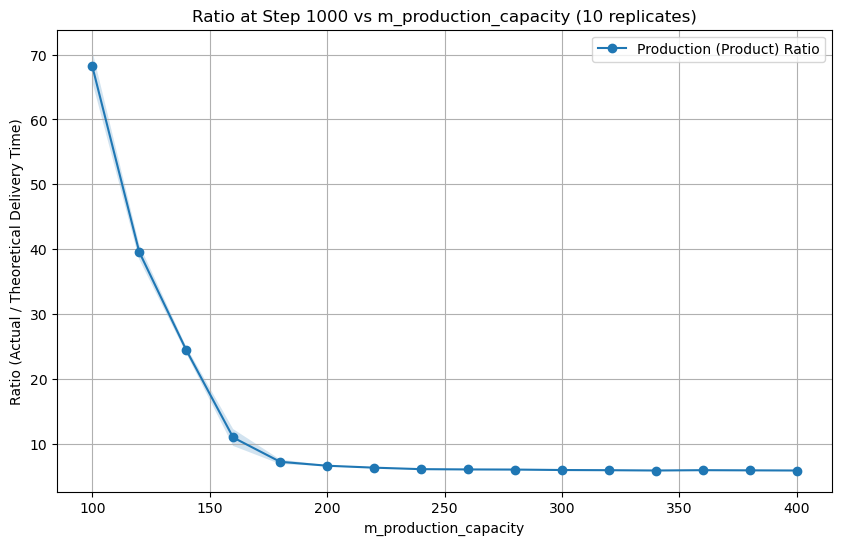

In [13]:
total_steps = 2000
num_replicates = 2
m_production_values = range(100,420,20)
prod_results = []  # 每个 m_production_capacity 下的 product ratio 列表
mat_results = []   # 每个 m_production_capacity 下的 material ratio 列表
for m_prod in m_production_values:
    prod_list = []
    mat_list = []
    for rep in range(num_replicates):
        model = SupplyChainGridModel(cust_positions=cust_pos,
                 man_positions=man_pos,
                 sup_positions=sup_pos,
                 demands_list=demands_list,
                 inventory_list=inventory_list,                 
                 cust_demand_multiplier=1.0,
                 m_production_capacity=m_prod,
                 m_inventory_capacity_product=700,
                 m_inventory_capacity_material=1000,
                 s_material_capacity=200,
                 agent_mode="homogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
                 logistics_speed=1000,
                 rm_procurement_mode="gap_based",
                 rm_reorder_point=400,
                 rm_reorder_target=900,
                 rm_purchase_multiplier=1.2,
                 rm_produce_multiplier=1.2,
                 product_order_mode="normal",
                 material_order_mode="normal",
                 num_customers=36,
                 num_manufacturers=6,
                 num_suppliers=14)
        for t in range(1, total_steps+1):
            model.step()
        prod_orders = [o for o in model.delivered_orders if o.order_type == "product" and o.actual_delivery_time is not None]
        sum_actual_prod = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical_prod = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual_prod / sum_theoretical_prod if sum_theoretical_prod > 0 else None
        prod_list.append(ratio_prod if ratio_prod is not None else 0)
    prod_results.append(prod_list)



# 计算均值和标准差
prod_means = [np.mean(x) for x in prod_results]
prod_stds = [np.std(x) for x in prod_results]

plt.figure(figsize=(10,6))
x = np.array(list(m_production_values))
prod_means = np.array(prod_means)
prod_stds = np.array(prod_stds)
plt.plot(x, prod_means, 'o-', label='Production (Product) Ratio')
plt.fill_between(x, prod_means - prod_stds, prod_means + prod_stds, alpha=0.2)
plt.xlabel('m_production_capacity')
plt.ylabel('Ratio (Actual / Theoretical Delivery Time)')
plt.title('Ratio at Step 1000 vs m_production_capacity (10 replicates)')
plt.legend()
plt.grid(True)
plt.show()

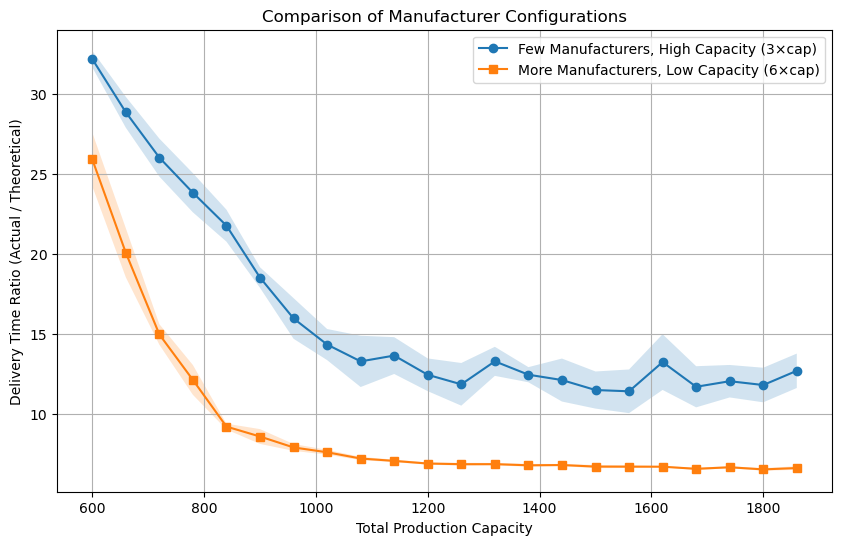

In [8]:
total_steps = 500
num_replicates = 5
prod_results_A = []  # Scenario A: few manufacturers, high capacity
prod_results_B = []  # Scenario B: more manufacturers, low capacity
total_capacities = []

# 设置匹配的单个产能值（保证总产能覆盖相同区间）
capacity_values_A = range(200, 640, 20)  # for 3 manufacturers
capacity_values_B = range(100, 320, 10)   # for 6 manufacturers

for cap_A, cap_B in zip(capacity_values_A, capacity_values_B):
    total_capacity = cap_A * 3  # or cap_B * 6，二者应相等
    total_capacities.append(total_capacity)

    prod_list_A = []
    prod_list_B = []

    # 情景 A：少量制造商，高产能
    for rep in range(num_replicates):
        model = SupplyChainGridModel(
            cust_positions=cust_pos,
                 man_positions=man_pos,
                 sup_positions=sup_pos,
                 demands_list=demands_list,
                 inventory_list=inventory_list,                 
                 cust_demand_multiplier=1.0,
                 m_production_capacity=cap_A,
                 m_inventory_capacity_product=400,
                 m_inventory_capacity_material=800,
                 s_material_capacity=240,
                 agent_mode="homogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
                 logistics_speed=2.0,
                 rm_procurement_mode="gap_based",
                 rm_reorder_point=400,
                 rm_reorder_target=800,
                 rm_purchase_multiplier=1.5,
                 rm_produce_multiplier=1.5,
                 product_order_mode="normal",
                 material_order_mode="normal",
                 num_customers=36,
                 num_manufacturers=3,
                 num_suppliers=14,
            # 其余参数略（与你已有代码一致）
        )
        for t in range(1, total_steps+1):
            model.step()
        prod_orders = [o for o in model.delivered_orders if o.order_type == "product" and o.actual_delivery_time]
        ratio = sum(o.actual_delivery_time for o in prod_orders) / sum(o.theoretical_delivery_time for o in prod_orders)
        prod_list_A.append(ratio)

    # 情景 B：多个制造商，低产能
    for rep in range(num_replicates):
        model = SupplyChainGridModel(
            cust_positions=cust_pos,
                 man_positions=man_pos,
                 sup_positions=sup_pos,
                 demands_list=demands_list,
                 inventory_list=inventory_list,                 
                 cust_demand_multiplier=1.0,
                 m_production_capacity=cap_B,
                 m_inventory_capacity_product=400,
                 m_inventory_capacity_material=800,
                 s_material_capacity=240,
                 agent_mode="homogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
                 logistics_speed=2.0,
                 rm_procurement_mode="gap_based",
                 rm_reorder_point=400,
                 rm_reorder_target=800,
                 rm_purchase_multiplier=1.5,
                 rm_produce_multiplier=1.5,
                 product_order_mode="normal",
                 material_order_mode="normal",
                 num_customers=36,
                 num_manufacturers=6,
                 num_suppliers=14
            # 其余参数略
        )
        for t in range(1, total_steps+1):
            model.step()
        prod_orders = [o for o in model.delivered_orders if o.order_type == "product" and o.actual_delivery_time]
        ratio = sum(o.actual_delivery_time for o in prod_orders) / sum(o.theoretical_delivery_time for o in prod_orders)
        prod_list_B.append(ratio)

    prod_results_A.append(prod_list_A)
    prod_results_B.append(prod_list_B)

# 计算均值和标准差
means_A = [np.mean(x) for x in prod_results_A]
stds_A  = [np.std(x) for x in prod_results_A]
means_B = [np.mean(x) for x in prod_results_B]
stds_B  = [np.std(x) for x in prod_results_B]

# 绘图
x = np.array(total_capacities)
plt.figure(figsize=(10,6))
plt.plot(x, means_A, 'o-', label='Few Manufacturers, High Capacity (3×cap)')
plt.fill_between(x, np.array(means_A)-np.array(stds_A), np.array(means_A)+np.array(stds_A), alpha=0.2)

plt.plot(x, means_B, 's-', label='More Manufacturers, Low Capacity (6×cap)')
plt.fill_between(x, np.array(means_B)-np.array(stds_B), np.array(means_B)+np.array(stds_B), alpha=0.2)

plt.xlabel('Total Production Capacity')
plt.ylabel('Delivery Time Ratio (Actual / Theoretical)')
plt.title('Comparison of Manufacturer Configurations')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# total_steps, model 定义前已准备好
total_steps = 2000
num_replicates = 5
m_production_values = list(range(100, 300, 10))
ratio_vals = m_production_values
win = 2000  # 滑动窗口

# 三组参数配置：物料产能、物流速度、图例名称
configurations = [
    (100, 1000, "Material=100, Logistics=1000"),
    (300, 1000, "Material=300, Logistics=1000"),
    (100, 3000, "Material=100, Logistics=3000"),
]

# 保存三个指标的结果
edge_results = []  # Weighted Edge Count
cost_results = []  # Unit Cost
ratio_results = [] # Fulfillment Ratio

for s_material_capacity, logistics_speed, label in configurations:
    edge_means, edge_stds = [], []
    cost_means, cost_stds = [], []
    ratio_means, ratio_stds = [], []

    for m_prod in m_production_values:
        edge_list = []
        cost_list = []
        ratio_list = []

        for rep in range(num_replicates):
            model = SupplyChainGridModel(
                cust_positions=cust_pos,
                man_positions=man_pos,
                sup_positions=sup_pos,
                demands_list=demands_list,
                inventory_list=inventory_list,
                cust_demand_multiplier=1.0,
                m_production_capacity=m_prod,
                m_inventory_capacity_product=700,
                m_inventory_capacity_material=1000,
                s_material_capacity=s_material_capacity,
                agent_mode="homogeneous",
                logistics_speed=logistics_speed,
                rm_procurement_mode="gap_based",
                rm_reorder_point=400,
                rm_reorder_target=900,
                rm_purchase_multiplier=1,
                rm_produce_multiplier=1,
                product_order_mode="normal",
                material_order_mode="normal",
                num_customers=36,
                num_manufacturers=6,
                num_suppliers=14
            )

            for _ in range(total_steps):
                model.step()

            edge = get_weighted_edge_count(model, win=win)
            cost = calculate_unit_cost_window(model, win=win)
            ratio = calculate_ratio_window(model, win=win)

            edge_list.append(edge)
            cost_list.append(cost)
            ratio_list.append(ratio)

        edge_means.append(np.mean(edge_list))
        edge_stds.append(np.std(edge_list))
        cost_means.append(np.mean(cost_list))
        cost_stds.append(np.std(cost_list))
        ratio_means.append(np.mean(ratio_list))
        ratio_stds.append(np.std(ratio_list))

    edge_results.append((label, edge_means, edge_stds))
    cost_results.append((label, cost_means, cost_stds))
    ratio_results.append((label, ratio_means, ratio_stds))

# ---------- 画图：1. Weighted Edge Count ----------
plt.figure(figsize=(10, 6))
for label, means, stds in edge_results:
    plt.plot(ratio_vals, means, label=label)
    plt.fill_between(ratio_vals, np.array(means) - stds, np.array(means) + stds, alpha=0.2)
plt.xlabel('m_production_capacity')
plt.ylabel('Weighted Edge Count')
plt.title('Weighted Edge Count vs Production Capacity')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ---------- 画图：2. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, means, stds in cost_results:
    plt.plot(ratio_vals, means, label=label)
    plt.fill_between(ratio_vals, np.array(means) - stds, np.array(means) + stds, alpha=0.2)
plt.xlabel('m_production_capacity')
plt.ylabel('Unit Cost')
plt.title('Unit Cost vs Production Capacity')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ---------- 画图：3. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, means, stds in ratio_results:
    plt.plot(ratio_vals, means, label=label)
    plt.fill_between(ratio_vals, np.array(means) - stds, np.array(means) + stds, alpha=0.2)
plt.xlabel('m_production_capacity')
plt.ylabel('Order Time Ratio (Actual / Theoretical)')
plt.title('Order Time vs Production Capacity')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

KeyboardInterrupt: 

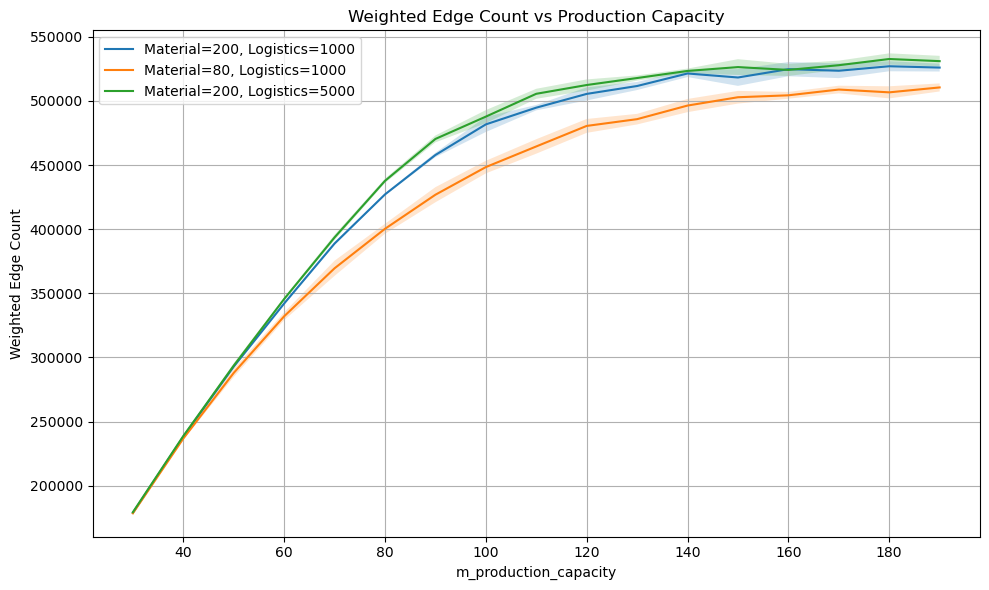

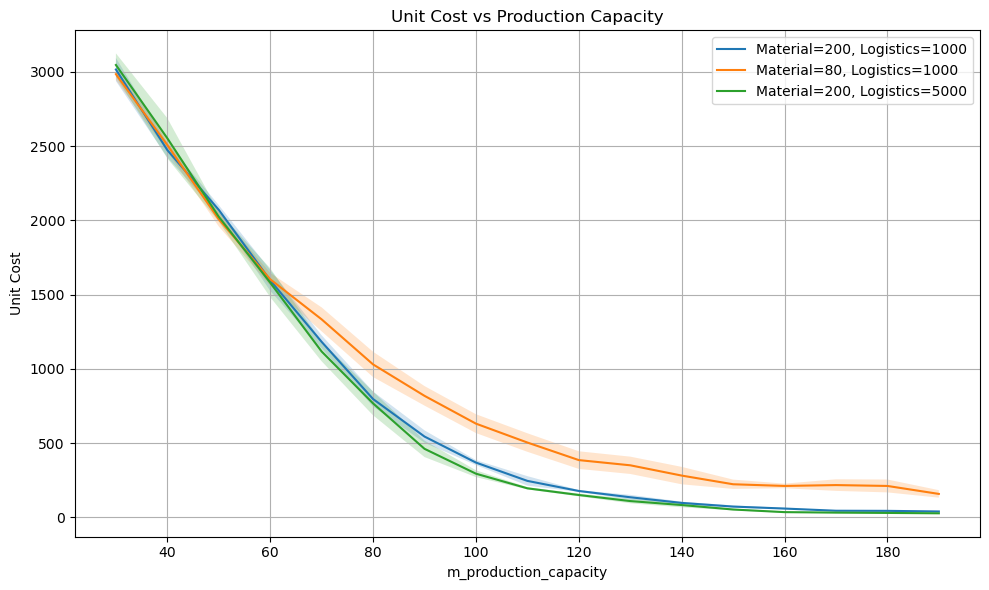

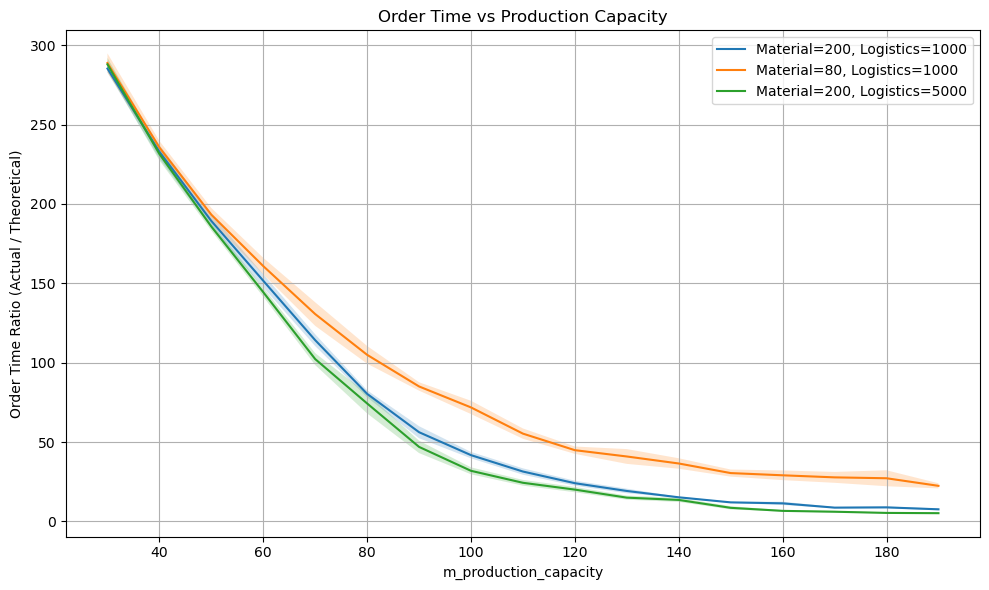

In [52]:
# total_steps, model 定义前已准备好
total_steps = 1000
num_replicates = 5
m_production_values = list(range(30, 200, 10))
ratio_vals = m_production_values
win = 1000  # 滑动窗口

# 三组参数配置：物料产能、物流速度、图例名称
configurations = [
    (200, 1000, "Material=200, Logistics=1000"),
    (80, 1000, "Material=80, Logistics=1000"),
    (200, 5000, "Material=200, Logistics=5000"),
]

# 保存三个指标的结果
edge_results = []  # Weighted Edge Count
cost_results = []  # Unit Cost
ratio_results = [] # Fulfillment Ratio

for s_material_capacity, logistics_speed, label in configurations:
    edge_means, edge_stds = [], []
    cost_means, cost_stds = [], []
    ratio_means, ratio_stds = [], []

    for m_prod in m_production_values:
        edge_list = []
        cost_list = []
        ratio_list = []

        for rep in range(num_replicates):
            model = SupplyChainGridModel(
                cust_positions=cust_pos,
                man_positions=man_pos,
                sup_positions=sup_pos,
                demands_list=demands_list,
                inventory_list=inventory_list,
                cust_demand_multiplier=1.0,
                m_production_capacity=m_prod,
                m_inventory_capacity_product=700,
                m_inventory_capacity_material=1000,
                s_material_capacity=s_material_capacity,
                agent_mode="homogeneous",
                logistics_speed=logistics_speed,
                rm_procurement_mode="gap_based",
                rm_reorder_point=400,
                rm_reorder_target=900,
                rm_purchase_multiplier=1,
                rm_produce_multiplier=1,
                product_order_mode="normal",
                material_order_mode="normal",
                num_customers=36,
                num_manufacturers=6,
                num_suppliers=14
            )

            for _ in range(total_steps):
                model.step()

            edge = get_weighted_edge_count(model, win=win)
            cost = calculate_unit_cost_window(model, win=win)
            ratio = calculate_ratio_window(model, win=win)

            edge_list.append(edge)
            cost_list.append(cost)
            ratio_list.append(ratio)

        edge_means.append(np.mean(edge_list))
        edge_stds.append(np.std(edge_list))
        cost_means.append(np.mean(cost_list))
        cost_stds.append(np.std(cost_list))
        ratio_means.append(np.mean(ratio_list))
        ratio_stds.append(np.std(ratio_list))

    edge_results.append((label, edge_means, edge_stds))
    cost_results.append((label, cost_means, cost_stds))
    ratio_results.append((label, ratio_means, ratio_stds))

# ---------- 画图：1. Weighted Edge Count ----------
plt.figure(figsize=(10, 6))
for label, means, stds in edge_results:
    plt.plot(ratio_vals, means, label=label)
    plt.fill_between(ratio_vals, np.array(means) - stds, np.array(means) + stds, alpha=0.2)
plt.xlabel('m_production_capacity')
plt.ylabel('Weighted Edge Count')
plt.title('Weighted Edge Count vs Production Capacity')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ---------- 画图：2. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, means, stds in cost_results:
    plt.plot(ratio_vals, means, label=label)
    plt.fill_between(ratio_vals, np.array(means) - stds, np.array(means) + stds, alpha=0.2)
plt.xlabel('m_production_capacity')
plt.ylabel('Unit Cost')
plt.title('Unit Cost vs Production Capacity')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ---------- 画图：3. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, means, stds in ratio_results:
    plt.plot(ratio_vals, means, label=label)
    plt.fill_between(ratio_vals, np.array(means) - stds, np.array(means) + stds, alpha=0.2)
plt.xlabel('m_production_capacity')
plt.ylabel('Order Time Ratio (Actual / Theoretical)')
plt.title('Order Time vs Production Capacity')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

In [7]:
def run_simulation_with_param_changes(cust_positions=cust_pos,
        man_positions=man_pos,
        sup_positions=sup_pos,
        cust_demand_multiplier=1.0,
        m_production_capacity=150,
        m_inventory_capacity_product=400,
        m_inventory_capacity_material=800,
        s_material_capacity=140,
        agent_mode="heterogeneous",
        logistics_speed=1000,
        rm_procurement_mode="gap_based",
        rm_reorder_point=30,
        rm_reorder_target=500,
        rm_purchase_multiplier=1.1,
        rm_produce_multiplier=1.1,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=1000,
        num_reps=2,
        change_schedule=None,
        return_model=False,
        num_customers=36,
        num_manufacturers=6,
        num_suppliers=14
):
    """
    运行 num_reps 次仿真，并在运行过程中按 change_schedule 更新参数。
    返回：
        mean_prod_ratio:      平均时效比（可删）
        mean_unit_cost:       平均单位成本（可删）
        mean_edge_series:     每步平均加权边数
        std_edge_series:      每步加权边数标准差
        phase_metrics:        各阶段指标 (ratio, unit_cost, 完成量)
        mean_ratio_series:    每步平均时效比
        std_ratio_series:     每步时效比标准差
        mean_unit_cost_series: 每步平均单位成本
        std_unit_cost_series:  每步单位成本标准差
    """
    weighted_edge_count_list = []

    ratio_series_list = []
    unit_cost_series_list = []
    WIN = 2000

    for rep in range(num_reps):
        try:
            from SCN.agent import used_positions
            used_positions.clear()
        except:
            pass

        model = SupplyChainGridModel(
            cust_positions=cust_pos,
            man_positions=man_pos,
            sup_positions=sup_pos,
            demands_list=demands_list,
            inventory_list=inventory_list,
            num_customers=num_customers,
            num_manufacturers=num_manufacturers,
            num_suppliers=num_suppliers,
            cust_demand_probability=0.4,
            cust_demand_multiplier=cust_demand_multiplier,
            m_production_capacity=m_production_capacity,
            m_inventory_capacity_product=m_inventory_capacity_product,
            m_inventory_capacity_material=m_inventory_capacity_material,
            s_material_capacity=s_material_capacity,
            agent_mode=agent_mode,
            logistics_speed=logistics_speed,
            rm_procurement_mode=rm_procurement_mode,
            rm_reorder_point=rm_reorder_point,
            rm_reorder_target=rm_reorder_target,
            rm_purchase_multiplier=rm_purchase_multiplier,
            rm_produce_multiplier=rm_produce_multiplier,
            product_order_mode=product_order_mode,
            material_order_mode=material_order_mode
        )
        def _applicable(agents):
            # 如果是区域异质模式，只返回右侧 5 列的 agents，否则返回全部
            if model.agent_mode == "regional_heterogeneous":
                return [a for a in agents if a.pos[0] >= 35]
            else:
                return agents

        rep_edge_series = []
        rep_ratio_series = []
        rep_unit_cost_series = []

        if change_schedule:
            points = sorted(p for p in change_schedule if 0 < p <= total_steps)
        else:
            points = []
        points.append(total_steps)
        snapshots = [(0, 0, 0, 0)]
        next_change_index = 0

        for current_step in range(1, total_steps+1):
            model.step()

            # 记录 weighted edge count
            current_weighted_edge_count= get_weighted_edge_count(model,2000)

            # 记录当前时效比 & 单位成本
            current_ratio = calculate_ratio_window(model, 2000)
            current_uc    = calculate_unit_cost_window(model, 2000)
            if current_uc is None:
                current_uc = 0 

            rep_ratio_series.append(current_ratio)
            rep_unit_cost_series.append(current_uc)
            rep_edge_series.append(current_weighted_edge_count)
            # 参数变更处理
            if change_schedule and current_step in change_schedule:
                changes = change_schedule[current_step]
                if "product_order_mode" in changes:
                    for c in _applicable(model.customers):
                        c.order_mode = changes["product_order_mode"]
                if "cust_demand_multiplier" in changes:
                    for c in _applicable(model.customers):
                        c.cust_demand_multiplier = changes["cust_demand_multiplier"]
                if "logistics_speed" in changes:
                    model.logistics_speed = changes["logistics_speed"]
                if "m_production_capacity" in changes:
                    for m in _applicable(model.manufacturers):
                        m.production_capacity = changes["m_production_capacity"]
                if "rm_procurement_mode" in changes:
                    for m in _applicable(model.manufacturers):
                        m.rm_procurement_mode = changes["rm_procurement_mode"]
                if "rm_purchase_multiplier" in changes:
                    for m in _applicable(model.manufacturers):
                        m.rm_purchase_multiplier = changes["rm_purchase_multiplier"]
                if "material_order_mode" in changes:
                    for m in _applicable(model.manufacturers):
                        m.material_order_mode = changes["material_order_mode"]
                if "m_inventory_capacity_material" in changes:
                    for m in _applicable(model.manufacturers):
                        m.inventory_capacity_material = changes["m_inventory_capacity_material"]
                if "m_inventory_capacity_product" in changes:
                    for m in _applicable(model.manufacturers):
                        m.inventory_capacity_product = changes["m_inventory_capacity_product"]
                if "s_material_capacity" in changes:
                    for s in _applicable(model.suppliers):
                        s.material_capacity = changes["s_material_capacity"]
                if "agent_mode" in changes:
                    model.agent_mode = changes["agent_mode"]

    
        # 保存 rep 结果
        weighted_edge_count_list.append(rep_edge_series)
        ratio_series_list.append(rep_ratio_series)
        unit_cost_series_list.append(rep_unit_cost_series)


    # 计算跨 reps 的平均和 std
    edge_arr = np.array(weighted_edge_count_list)
    mean_edge = np.mean(edge_arr, axis=0)
    std_edge = np.std(edge_arr, axis=0)

    ratio_arr = np.array(ratio_series_list)
    mean_ratio = np.mean(ratio_arr, axis=0)
    std_ratio = np.std(ratio_arr, axis=0)

    uc_arr = np.array(unit_cost_series_list)
    mean_uc = np.mean(uc_arr, axis=0)
    std_uc = np.std(uc_arr, axis=0)

    results = (
        mean_edge,
        std_edge,
        mean_ratio,
        std_ratio,
        mean_uc,
        std_uc
    )
    return (model, results) if return_model else results

Running scenario: Strategy A
Running scenario: Strategy B
Running scenario: Strategy C


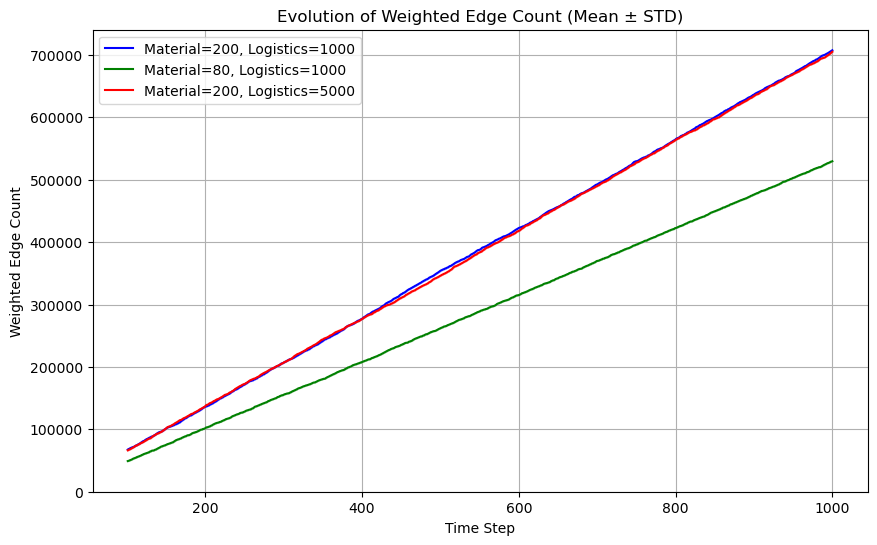

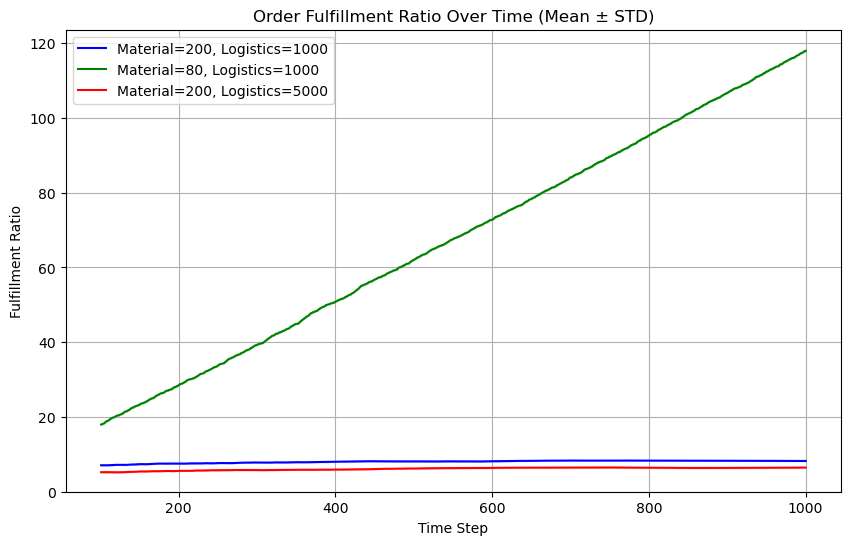

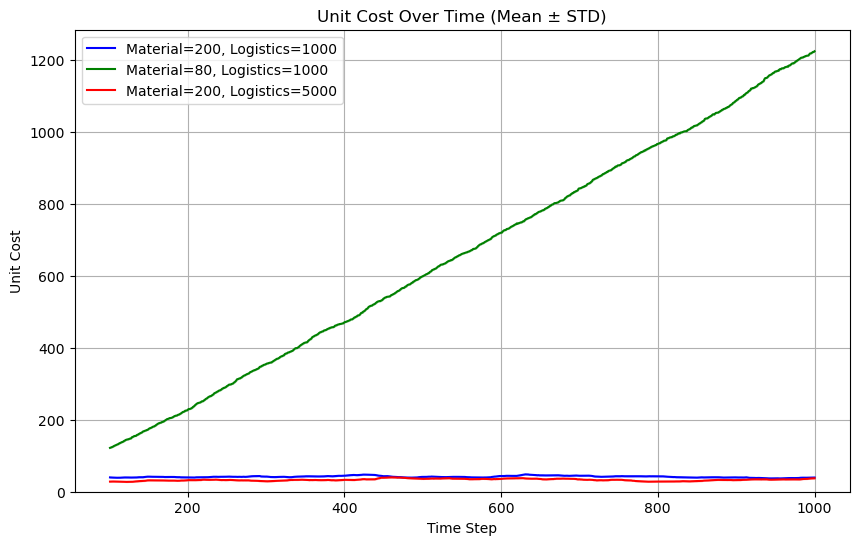

In [55]:
# material capacity change
change_schedule_A = {
}
change_schedule_B = {
    1: {"s_material_capacity": 80},

}
change_schedule_C = {
    1: {"logistics_speed": 5000}
}

total_steps = 1000
def run_scenario(scenario_name, change_schedule):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=300,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="homogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
        logistics_speed=1000.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1,
        rm_produce_multiplier=1,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=1000,
        num_reps=1,
        change_schedule=change_schedule,
        return_model=False,           
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }
# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)

time_steps = np.arange(1, total_steps + 1)
start = 100      
x = time_steps[start:]  
# 想裁掉前多少步
edge_dict = {
    "Material=200, Logistics=1000"   : ("blue"  , results_A),
    "Material=80, Logistics=1000"   : ("green" , results_B),
    "Material=200, Logistics=5000"   : ("red"   , results_C)
}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

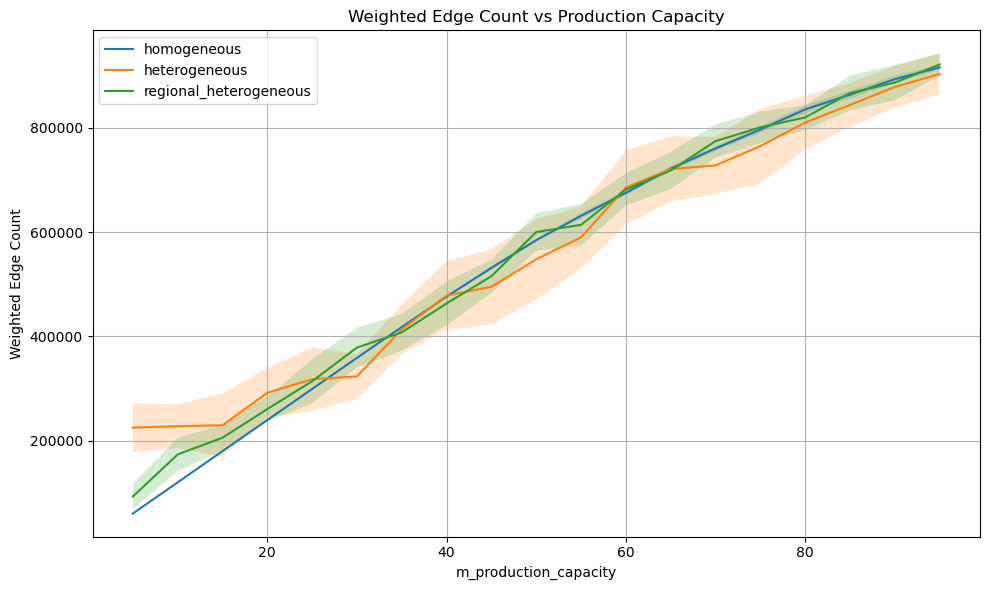

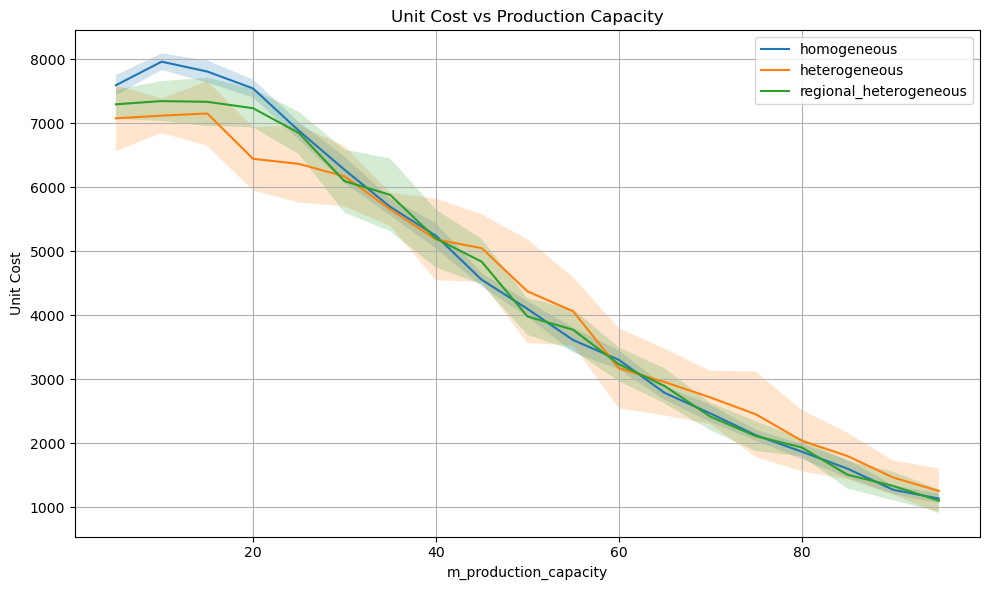

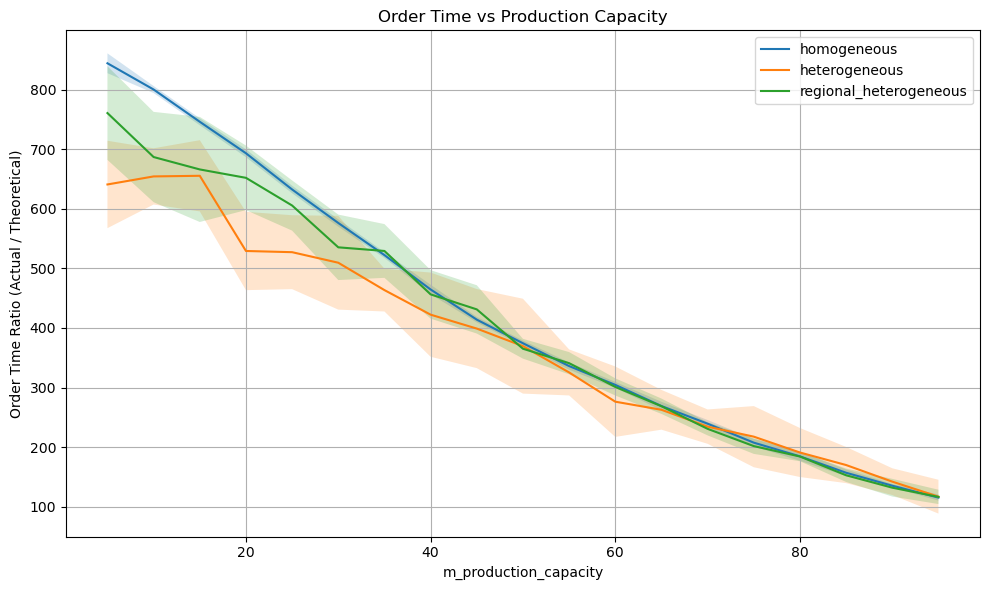

In [38]:
# total_steps, model 定义前已准备好
total_steps = 2000
num_replicates = 10
m_production_values = list(range(5, 100, 5))
ratio_vals = m_production_values
win = 2000  # 滑动窗口

# 三组参数配置：物料产能、物流速度、图例名称
configurations = [
    ("homogeneous", "homogeneous"),
    ("heterogeneous", "heterogeneous"),
    ("regional_heterogeneous", "regional_heterogeneous"),
]

# 保存三个指标的结果
edge_results = []  # Weighted Edge Count
cost_results = []  # Unit Cost
ratio_results = [] # Fulfillment Ratio

for agent_mode, label in configurations:
    edge_means, edge_stds = [], []
    cost_means, cost_stds = [], []
    ratio_means, ratio_stds = [], []

    for m_prod in m_production_values:
        edge_list = []
        cost_list = []
        ratio_list = []

        for rep in range(num_replicates):
            model = SupplyChainGridModel(
                cust_positions=cust_pos,
                man_positions=man_pos,
                sup_positions=sup_pos,
                demands_list=demands_list,
                inventory_list=inventory_list,
                cust_demand_multiplier=1.0,
                m_production_capacity=m_prod,
                m_inventory_capacity_product=700,
                m_inventory_capacity_material=1000,
                s_material_capacity=100,
                agent_mode=agent_mode,
                logistics_speed=1000,
                rm_procurement_mode="gap_based",
                rm_reorder_point=400,
                rm_reorder_target=900,
                rm_purchase_multiplier=1.2,
                rm_produce_multiplier=1.2,
                product_order_mode="normal",
                material_order_mode="normal",
                num_customers=36,
                num_manufacturers=6,
                num_suppliers=14
            )

            for _ in range(total_steps):
                model.step()

            edge = get_weighted_edge_count(model, win=win)
            cost = calculate_unit_cost_window(model, win=win)
            ratio = calculate_ratio_window(model, win=win)

            edge_list.append(edge)
            cost_list.append(cost)
            ratio_list.append(ratio)

        edge_means.append(np.mean(edge_list))
        edge_stds.append(np.std(edge_list))
        cost_means.append(np.mean(cost_list))
        cost_stds.append(np.std(cost_list))
        ratio_means.append(np.mean(ratio_list))
        ratio_stds.append(np.std(ratio_list))

    edge_results.append((label, edge_means, edge_stds))
    cost_results.append((label, cost_means, cost_stds))
    ratio_results.append((label, ratio_means, ratio_stds))

# ---------- 画图：1. Weighted Edge Count ----------
plt.figure(figsize=(10, 6))
for label, means, stds in edge_results:
    plt.plot(ratio_vals, means, label=label)
    plt.fill_between(ratio_vals, np.array(means) - stds, np.array(means) + stds, alpha=0.2)
plt.xlabel('m_production_capacity')
plt.ylabel('Weighted Edge Count')
plt.title('Weighted Edge Count vs Production Capacity')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ---------- 画图：2. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, means, stds in cost_results:
    plt.plot(ratio_vals, means, label=label)
    plt.fill_between(ratio_vals, np.array(means) - stds, np.array(means) + stds, alpha=0.2)
plt.xlabel('m_production_capacity')
plt.ylabel('Unit Cost')
plt.title('Unit Cost vs Production Capacity')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ---------- 画图：3. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, means, stds in ratio_results:
    plt.plot(ratio_vals, means, label=label)
    plt.fill_between(ratio_vals, np.array(means) - stds, np.array(means) + stds, alpha=0.2)
plt.xlabel('m_production_capacity')
plt.ylabel('Order Time Ratio (Actual / Theoretical)')
plt.title('Order Time vs Production Capacity')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

Running scenario: Strategy A
Running scenario: Strategy B
Running scenario: Strategy C


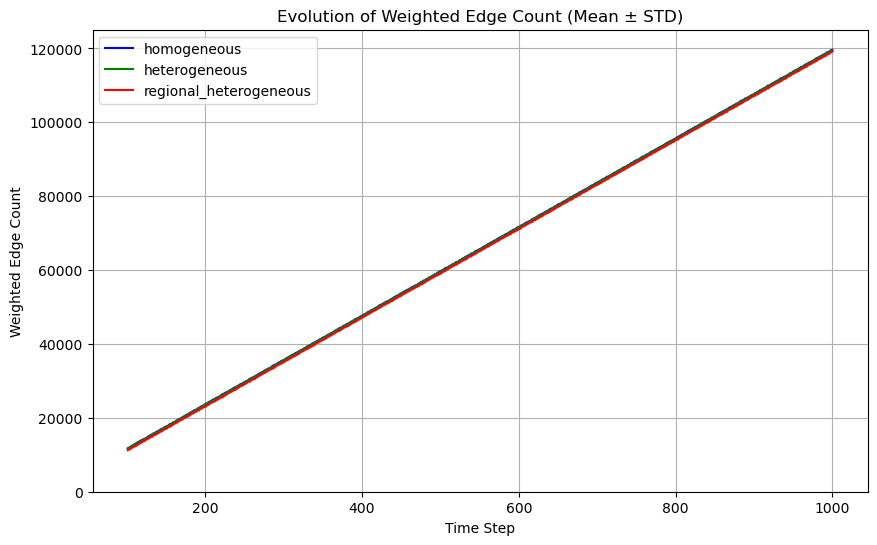

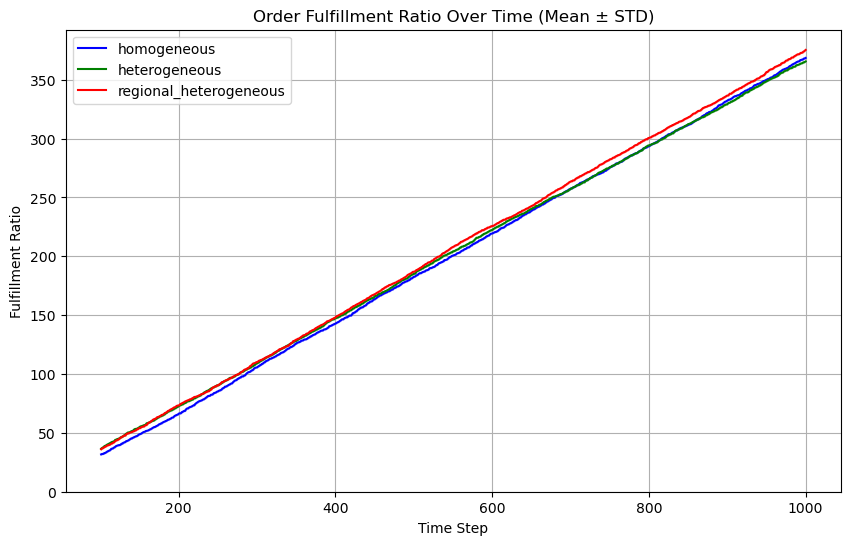

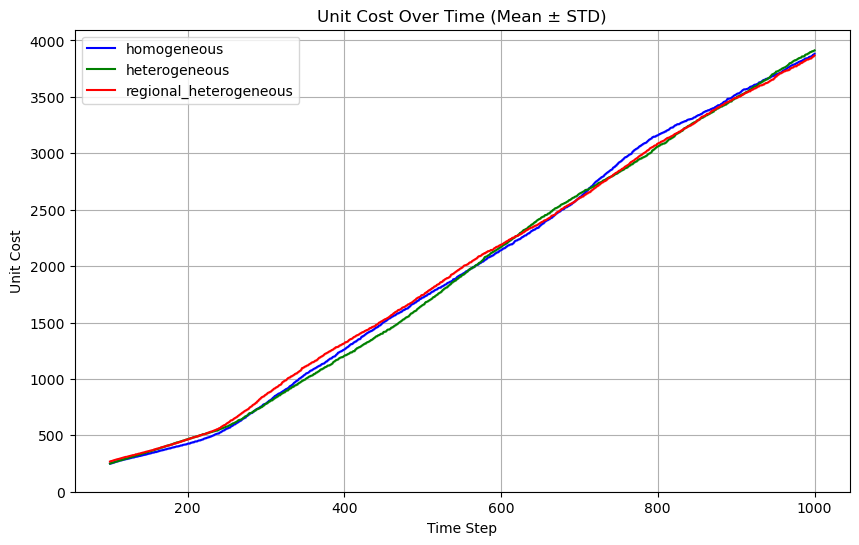

In [42]:
# material capacity change
change_schedule_A = {
}
change_schedule_B = {
    1: {"agent_mode": "heterogeneous"},

}
change_schedule_C = {
    1: {"agent_mode": "regional_heterogeneous"}
}

total_steps = 1000
def run_scenario(scenario_name, change_schedule):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=20,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=100,
        agent_mode= "homogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
        logistics_speed=1000.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=1000,
        num_reps=1,
        change_schedule=change_schedule,
        return_model=False,           
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }
# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)

time_steps = np.arange(1, total_steps + 1)
start = 100      
x = time_steps[start:]  
# 想裁掉前多少步
edge_dict = {
    "homogeneous"   : ("blue"  , results_A),
    "heterogeneous"   : ("green" , results_B),
    "regional_heterogeneous"   : ("red"   , results_C)
}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


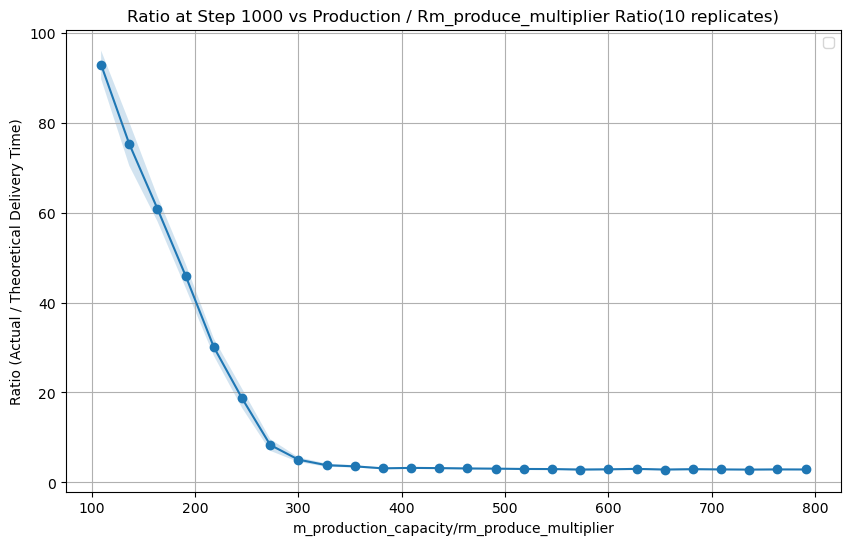

In [28]:
total_steps = 1000
num_replicates = 10
m_production_values = range(20,150,5)
rm_produce_multiplier = 1.1  # 你的固定物料能力
num_manufacturers=6
num_suppliers=4
prod_results = []  # 每个 m_production_capacity 下的 product ratio 列表

for m_prod in m_production_values:
    prod_list = []
    for rep in range(num_replicates):
        model = SupplyChainGridModel(
            positions=positions,
            demands_list=demands_list,
            inventory_list=inventory_list,                 
            cust_demand_multiplier=1.0,
            m_production_capacity=m_prod,
            m_inventory_capacity_product=300,
            m_inventory_capacity_material=600,
            s_material_capacity=400,
            m_cap_mode="homogeneous",
            logistics_speed=2.0,
            rm_procurement_mode="gap_based",
            rm_reorder_point=300,
            rm_reorder_target=600,
            rm_purchase_multiplier=1.1,
            rm_produce_multiplier=rm_produce_multiplier,
            product_order_mode="normal",
            material_order_mode="normal",
            num_customers=20,
            num_manufacturers=6,
            num_suppliers=4
        )
        for t in range(1, total_steps+1):
            model.step()
        # 统计 delivered_orders 中的 product
        prod_orders = [
            o for o in model.delivered_orders
            if o.order_type=="product" and o.actual_delivery_time is not None
        ]
        sum_actual = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual / sum_theoretical if sum_theoretical>0 else 0
        prod_list.append(ratio_prod)
    prod_results.append(prod_list)

# 计算均值和标准差
prod_means = np.array([np.mean(lst) for lst in prod_results])
prod_stds  = np.array([np.std(lst)  for lst in prod_results])

# 这里算出“生产能力/物料能力”的比值
ratio_vals = np.array([(m_prod*num_manufacturers)/(rm_produce_multiplier)for m_prod in m_production_values])

plt.figure(figsize=(10,6))
plt.plot(ratio_vals, prod_means, 'o-')
plt.fill_between(ratio_vals,
                 prod_means - prod_stds,
                 prod_means + prod_stds,
                 alpha=0.2)
plt.xlabel('m_production_capacity/rm_produce_multiplier')
plt.ylabel('Ratio (Actual / Theoretical Delivery Time)')
plt.title('Ratio at Step 1000 vs Production / Rm_produce_multiplier Ratio(10 replicates)')
plt.legend()
plt.grid(True)
plt.show()

Scan m_prod: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [29:36<00:00, 88.81s/it]


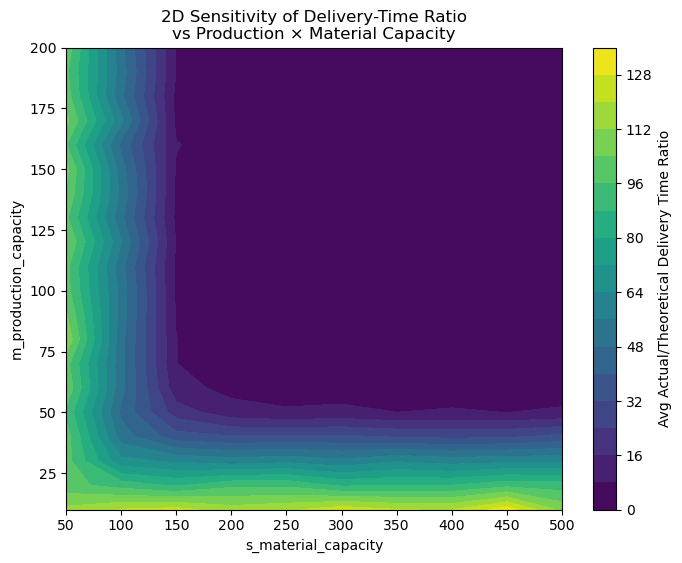

In [23]:
from tqdm import tqdm
TOTAL_STEPS     = 1000
NUM_REPLICATES  = 2
NUM_SUPPLIERS   = 4
NUM_MANUFACTURERS = 6

# 扫描范围
m_vals = np.arange(10, 201, 10)   # 生产能力 从 10 到 200，每 10 一步
s_vals = np.arange(50, 501, 50)   # 物料能力 从 50 到 500，每 50 一步

results = np.zeros((len(m_vals), len(s_vals)))

# 双重循环
for i, m_prod in enumerate(tqdm(m_vals, desc="Scan m_prod")):
    for j, s_mat in enumerate(tqdm(s_vals, desc="Scan s_mat", leave=False)):
        ratios = []
        for rep in range(NUM_REPLICATES):
            model = SupplyChainGridModel(
                positions=positions,
                demands_list=demands_list,
                inventory_list=inventory_list,
                cust_demand_multiplier=1.0,
                m_production_capacity=m_prod,
                m_inventory_capacity_product=300,
                m_inventory_capacity_material=600,
                s_material_capacity=s_mat,
                m_cap_mode="homogeneous",
                logistics_speed=2.0,
                rm_procurement_mode="gap_based",
                rm_reorder_point=300,
                rm_reorder_target=600,
                rm_purchase_multiplier=1.1,
                rm_produce_multiplier=1.1,
                product_order_mode="normal",
                material_order_mode="normal",
                num_customers=20,
                num_manufacturers=NUM_MANUFACTURERS,
                num_suppliers=NUM_SUPPLIERS
            )
            # 运行若干步
            for _ in range(TOTAL_STEPS):
                model.step()

            # 收集所有已完成的“产品”订单
            prod_orders = [
                o for o in model.delivered_orders
                if o.order_type=="product" and o.actual_delivery_time is not None
            ]
            actual   = sum(o.actual_delivery_time   for o in prod_orders)
            theoretical = sum(o.theoretical_delivery_time for o in prod_orders)
            ratio = (actual / theoretical) if theoretical>0 else 0
            ratios.append(ratio)

        results[i, j] = np.mean(ratios)
        
# 绘制等高线填色图
X, Y = np.meshgrid(s_vals, m_vals)  # X 轴：s_material_capacity, Y 轴：m_production_capacity

plt.figure(figsize=(8,6))
cp = plt.contourf(X, Y, results, levels=20, cmap="viridis")
plt.colorbar(cp, label="Avg Actual/Theoretical Delivery Time Ratio")
plt.xlabel("s_material_capacity")
plt.ylabel("m_production_capacity")
plt.title("2D Sensitivity of Delivery‐Time Ratio\nvs Production × Material Capacity")
plt.show()

In [19]:
def run_simulation_with_param_changes(cust_positions=cust_pos,
        man_positions=man_pos,
        sup_positions=sup_pos,
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="heterogeneous",
        logistics_speed=1000,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=1000,
        num_reps=1,
        change_schedule=None,
        return_model=False,
        num_customers=36,
        num_manufacturers=6,
        num_suppliers=14
):
    """
    运行 num_reps 次仿真，并在运行过程中按 change_schedule 更新参数。
    返回：
        mean_prod_ratio:      平均时效比（可删）
        mean_unit_cost:       平均单位成本（可删）
        mean_edge_series:     每步平均加权边数
        std_edge_series:      每步加权边数标准差
        phase_metrics:        各阶段指标 (ratio, unit_cost, 完成量)
        mean_ratio_series:    每步平均时效比
        std_ratio_series:     每步时效比标准差
        mean_unit_cost_series: 每步平均单位成本
        std_unit_cost_series:  每步单位成本标准差
    """
    weighted_edge_count_list = []

    ratio_series_list = []
    unit_cost_series_list = []
    WIN = 100  

    for rep in range(num_reps):
        try:
            from SCN.agent import used_positions
            used_positions.clear()
        except:
            pass

        model = SupplyChainGridModel(
            cust_positions=cust_pos,
            man_positions=man_pos,
            sup_positions=sup_pos,
            demands_list=demands_list,
            inventory_list=inventory_list,
            num_customers=num_customers,
            num_manufacturers=num_manufacturers,
            num_suppliers=num_suppliers,
            cust_demand_probability=0.4,
            cust_demand_multiplier=cust_demand_multiplier,
            m_production_capacity=m_production_capacity,
            m_inventory_capacity_product=m_inventory_capacity_product,
            m_inventory_capacity_material=m_inventory_capacity_material,
            s_material_capacity=s_material_capacity,
            agent_mode=agent_mode,
            logistics_speed=logistics_speed,
            rm_procurement_mode=rm_procurement_mode,
            rm_reorder_point=rm_reorder_point,
            rm_reorder_target=rm_reorder_target,
            rm_purchase_multiplier=rm_purchase_multiplier,
            rm_produce_multiplier=rm_produce_multiplier,
            product_order_mode=product_order_mode,
            material_order_mode=material_order_mode
        )
        def _applicable(agents):
            # 如果是区域异质模式，只返回右侧 5 列的 agents，否则返回全部
            if model.agent_mode == "regional_heterogeneous":
                return [a for a in agents if a.pos[0] >= 35]
            else:
                return agents

        rep_edge_series = []
        rep_ratio_series = []
        rep_unit_cost_series = []

        if change_schedule:
            points = sorted(p for p in change_schedule if 0 < p <= total_steps)
        else:
            points = []
        points.append(total_steps)
        snapshots = [(0, 0, 0, 0)]
        next_change_index = 0

        for current_step in range(1, total_steps+1):
            model.step()

            # 记录 weighted edge count
            current_weighted_edge_count= get_weighted_edge_count(model,100)

            # 记录当前时效比 & 单位成本
            current_ratio = calculate_ratio_window(model, 100)
            current_uc    = calculate_unit_cost_window(model, 100)
            if current_uc is None:
                current_uc = 0 

            rep_ratio_series.append(current_ratio)
            rep_unit_cost_series.append(current_uc)
            rep_edge_series.append(current_weighted_edge_count)
            # 参数变更处理
            if change_schedule and current_step in change_schedule:
                changes = change_schedule[current_step]
                if "product_order_mode" in changes:
                    for c in _applicable(model.customers):
                        c.order_mode = changes["product_order_mode"]
                if "cust_demand_multiplier" in changes:
                    for c in _applicable(model.customers):
                        c.cust_demand_multiplier = changes["cust_demand_multiplier"]
                if "logistics_speed" in changes:
                    model.logistics_speed = changes["logistics_speed"]
                if "m_production_capacity" in changes:
                    for m in _applicable(model.manufacturers):
                        m.production_capacity = changes["m_production_capacity"]
                if "rm_procurement_mode" in changes:
                    for m in _applicable(model.manufacturers):
                        m.rm_procurement_mode = changes["rm_procurement_mode"]
                if "rm_purchase_multiplier" in changes:
                    for m in _applicable(model.manufacturers):
                        m.rm_purchase_multiplier = changes["rm_purchase_multiplier"]
                if "material_order_mode" in changes:
                    for m in _applicable(model.manufacturers):
                        m.material_order_mode = changes["material_order_mode"]
                if "m_inventory_capacity_material" in changes:
                    for m in _applicable(model.manufacturers):
                        m.inventory_capacity_material = changes["m_inventory_capacity_material"]
                if "m_inventory_capacity_product" in changes:
                    for m in _applicable(model.manufacturers):
                        m.inventory_capacity_product = changes["m_inventory_capacity_product"]
                if "s_material_capacity" in changes:
                    for s in _applicable(model.suppliers):
                        s.material_capacity = changes["s_material_capacity"]

    
        # 保存 rep 结果
        weighted_edge_count_list.append(rep_edge_series)
        ratio_series_list.append(rep_ratio_series)
        unit_cost_series_list.append(rep_unit_cost_series)


    # 计算跨 reps 的平均和 std
    edge_arr = np.array(weighted_edge_count_list)
    mean_edge = np.mean(edge_arr, axis=0)
    std_edge = np.std(edge_arr, axis=0)

    ratio_arr = np.array(ratio_series_list)
    mean_ratio = np.mean(ratio_arr, axis=0)
    std_ratio = np.std(ratio_arr, axis=0)

    uc_arr = np.array(unit_cost_series_list)
    mean_uc = np.mean(uc_arr, axis=0)
    std_uc = np.std(uc_arr, axis=0)

    results = (
        mean_edge,
        std_edge,
        mean_ratio,
        std_ratio,
        mean_uc,
        std_uc
    )
    return (model, results) if return_model else results

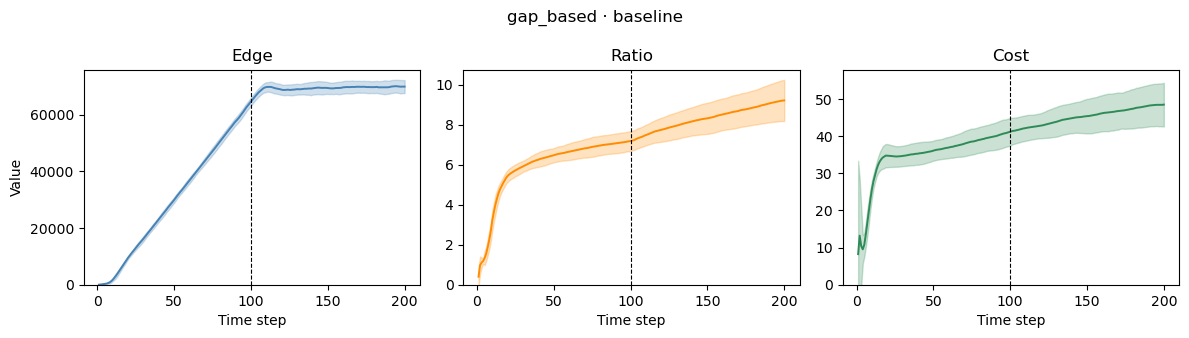

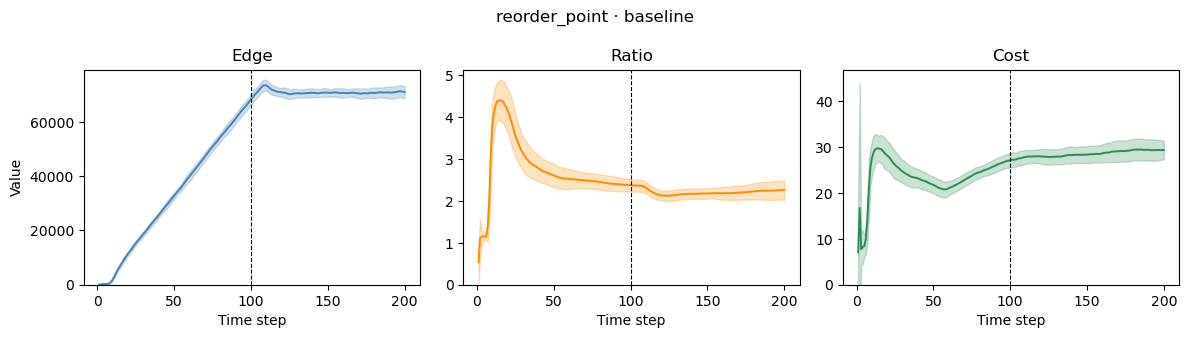

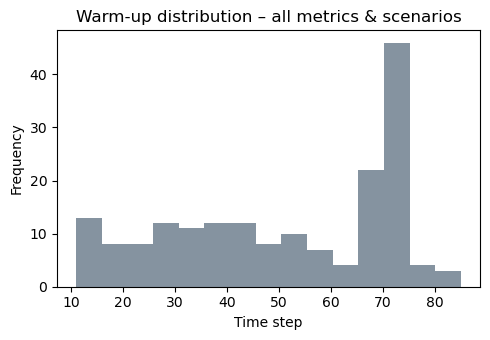

In [27]:
import json, pathlib, numpy as np, matplotlib.pyplot as plt

# ========= 实验设置 =========
TOTAL_STEPS   = 200
N_SEEDS       = 30
WINDOW        = 10
TOLERANCE     = 0.1
HOLD_STEPS    = 10
OUTDIR        = pathlib.Path("warmup_output")
OUTDIR.mkdir(exist_ok=True)

STRATEGY_ARGS = {
    "gap_based": dict(rm_procurement_mode="gap_based",
                      rm_purchase_multiplier=1.2,
                      rm_produce_multiplier=1.2,
                      rm_reorder_point=400,
                      rm_reorder_target=900),
    "reorder_point": dict(rm_procurement_mode="reorder_point",
                          rm_purchase_multiplier=1.2,
                          rm_produce_multiplier=1.2,
                          rm_reorder_point=400,
                          rm_reorder_target=900),
}

PARAM_SETS = {
    "baseline": dict(m_production_capacity=230, s_material_capacity=200),
}

# ========= 稳态步判定 =========
def first_stable_step(series: np.ndarray) -> int:
    mean_final = series.mean()
    mov_avg = np.convolve(series, np.ones(WINDOW) / WINDOW, mode="same")
    within = np.abs(mov_avg - mean_final) <= TOLERANCE * mean_final
    run = 0
    for i, ok in enumerate(within, start=1):
        run = run + 1 if ok else 0
        if run >= HOLD_STEPS:
            return max(1, i - HOLD_STEPS + 1)
    return TOTAL_STEPS

# ========= 折线 1×3 =========
def plot_three(edge_mat, ratio_mat, cost_mat, tag):
    x = np.arange(1, TOTAL_STEPS + 1)
    fig, ax = plt.subplots(1, 3, figsize=(12, 3.4), sharex=True)
    for k, (mat, title, col) in enumerate(
        [(edge_mat, "Edge", "steelblue"),
         (ratio_mat, "Ratio", "darkorange"),
         (cost_mat, "Cost", "seagreen")]):
        mat = np.array(mat)
        mean = mat.mean(axis=0)
        std = mat.std(axis=0)
        ax[k].plot(x, mean, color=col, lw=1.4)
        ax[k].fill_between(x, mean - std, mean + std, alpha=0.25, color=col)
        ax[k].axvline(100, ls="--", lw=0.8, c="black")
        ax[k].set_title(title); ax[k].set_ylim(bottom=0)
        ax[k].set_xlabel("Time step")
        if k == 0:
            ax[k].set_ylabel("Value")
    fig.suptitle(tag); fig.tight_layout(); plt.show()

# ========= 单组合实验 =========
GLOBAL_WARM_LIST = []     # 收集所有稳态步数，用于全局直方图

def run_one_setting(tag, strategy_key, param_key):
    strat = STRATEGY_ARGS[strategy_key]
    pars = PARAM_SETS[param_key]

    edge_mat, ratio_mat, cost_mat = [], [], []
    warm_stats = {"edge": [], "ratio": [], "cost": []}

    for seed in range(N_SEEDS):
        np.random.seed(seed)
        (mean_edge, _, mean_ratio, _, mean_cost, _) = \
            run_simulation_with_param_changes(
                num_reps=1,
                total_steps=TOTAL_STEPS,
                change_schedule=None,
                rm_purchase_multiplier=strat["rm_purchase_multiplier"],
                rm_produce_multiplier=strat["rm_produce_multiplier"],
                rm_procurement_mode=strat["rm_procurement_mode"],
                rm_reorder_point=strat["rm_reorder_point"],
                rm_reorder_target=strat["rm_reorder_target"],
                m_production_capacity=pars["m_production_capacity"],
                s_material_capacity=pars["s_material_capacity"],
            )

        edge_mat.append(mean_edge)
        ratio_mat.append(mean_ratio)
        cost_mat.append(mean_cost)

        warm_stats["edge"].append(first_stable_step(mean_edge))
        warm_stats["ratio"].append(first_stable_step(mean_ratio))
        warm_stats["cost"].append(first_stable_step(mean_cost))

    # 折线图
    plot_three(edge_mat, ratio_mat, cost_mat,
               f"{strategy_key} · {param_key}")

    # 将三类指标的稳态步加入全局列表
    for metric in ["edge", "ratio", "cost"]:
        GLOBAL_WARM_LIST.extend(warm_stats[metric])

    # 保存（可删）
    np.savez_compressed(OUTDIR / f"{tag}_raw.npz",
                        edge=np.array(edge_mat),
                        ratio=np.array(ratio_mat),
                        cost=np.array(cost_mat),
                        warmup=warm_stats)
    with open(OUTDIR / f"{tag}_summary.json", "w") as f:
        json.dump({k: list(map(int, v)) for k, v in warm_stats.items()}, f, indent=2)

# ========= 主程序 =========
if __name__ == "__main__":
    for strat in STRATEGY_ARGS:
        run_one_setting(f"exp_{strat}", strat, "baseline")

    # ---- 全局直方图 ----
    plt.figure(figsize=(5, 3.5))
    plt.hist(GLOBAL_WARM_LIST, bins=15, color="slategray", alpha=0.85)
    plt.xlabel("Time step")
    plt.ylabel("Frequency")
    plt.title("Warm-up distribution – all metrics & scenarios")
    plt.tight_layout()
    plt.show()